In [76]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from sklearn.datasets import make_blobs

In [77]:
# hyperparameters
num_class = 4
num_feature = 2
n_samples = 1000

# create data
X, y = make_blobs(n_samples,
                  n_features=num_feature, # X features
                  centers=num_class, # y labels
                  cluster_std=1.3)

In [78]:
# turn it to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [79]:
# split data
split = int(0.8 * len(X))

X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

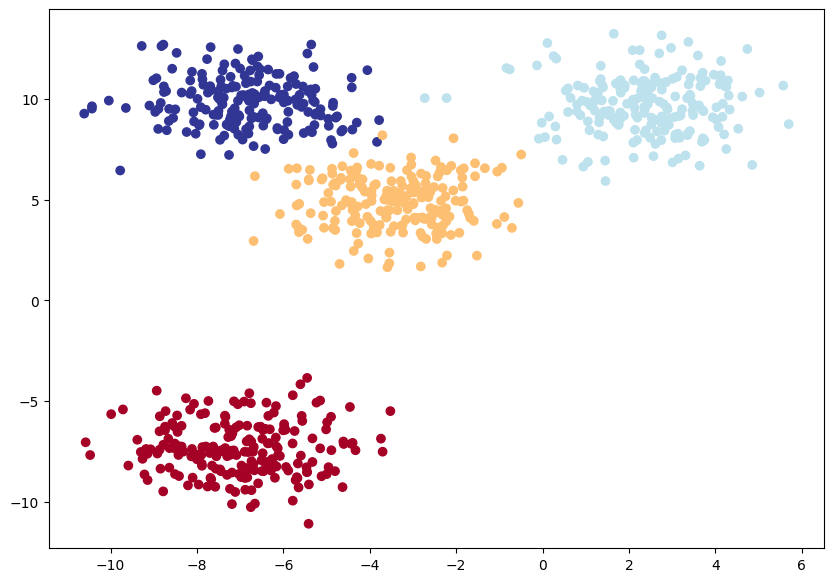

In [80]:
# plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_train[:, 0],
            X_train[:, 1],
            c=y_train,
            cmap=plt.cm.RdYlBu)

In [81]:
# model
class modelM(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=10):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.model(x)

model = modelM(2, 4)
model

modelM(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [82]:
# optimizer loss
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.1)

In [83]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [84]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print('helper_functions.py is exist, skipiing download')
else:
  print('downloading helper_functions.py')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)
from helper_functions import *

helper_functions.py is exist, skipiing download


In [86]:
# train
model = model.to(device)

epochs = 300

for epoch in range(epochs):
  model.train()
  logits = model(X_train) # raw output
  prob_d = torch.softmax(logits, dim=1) # softmax applied
  output = torch.argmax(prob_d, dim=1) # getting the max value per vector
  loss = loss_fn(logits, y_train.type(torch.long))
  acc = accuracy_fn(y_train, output)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_prob_d = torch.softmax(test_logits, dim=1)
    test_output = torch.argmax(test_prob_d, dim=1)

    test_loss = loss_fn(test_logits, y_test.type(torch.long))
    test_acc  = accuracy_fn(y_test, test_output)

  if epoch % 20 == 0:
    print(f'epoch: {epoch} | train loss: {loss:.5f} | test loss: {test_loss:.5f} | train acc: {acc:.2f}% | test acc: {test_acc:.2f}%')

epoch: 0 | train loss: 0.21738 | test loss: 0.20312 | train acc: 94.00% | test acc: 97.50%
epoch: 20 | train loss: 0.21943 | test loss: 0.19925 | train acc: 87.62% | test acc: 99.00%
epoch: 40 | train loss: 0.20252 | test loss: 0.18183 | train acc: 89.38% | test acc: 99.00%
epoch: 60 | train loss: 0.18578 | test loss: 0.16424 | train acc: 90.62% | test acc: 99.00%
epoch: 80 | train loss: 0.17099 | test loss: 0.14835 | train acc: 92.50% | test acc: 99.50%
epoch: 100 | train loss: 0.15789 | test loss: 0.13402 | train acc: 93.38% | test acc: 99.50%
epoch: 120 | train loss: 0.14603 | test loss: 0.12099 | train acc: 94.12% | test acc: 99.00%
epoch: 140 | train loss: 0.13422 | test loss: 0.10887 | train acc: 94.38% | test acc: 99.00%
epoch: 160 | train loss: 0.12430 | test loss: 0.09842 | train acc: 94.88% | test acc: 99.00%
epoch: 180 | train loss: 0.11377 | test loss: 0.08842 | train acc: 95.50% | test acc: 99.50%
epoch: 200 | train loss: 0.10515 | test loss: 0.08005 | train acc: 95.75% | 

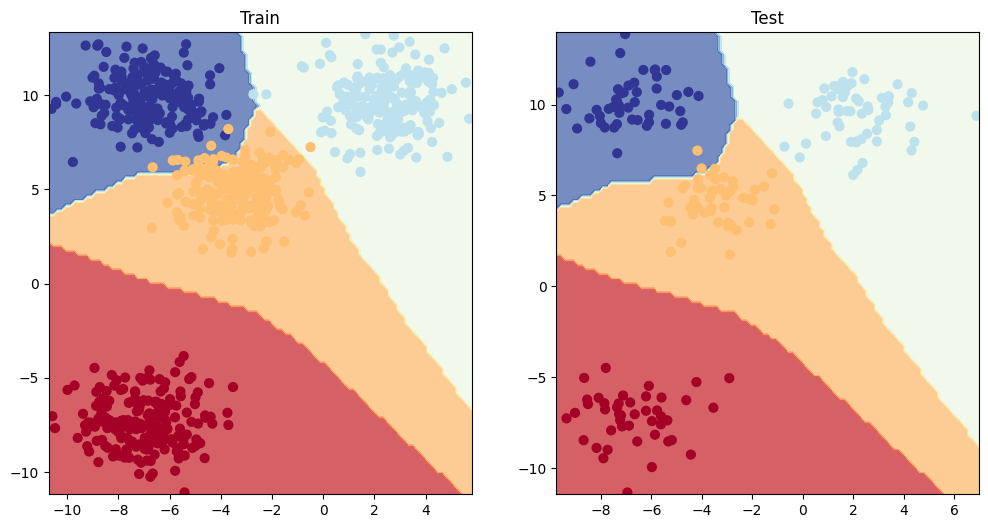

In [87]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)